## Importing libraries and modules

In [2]:
import pandas as pd
import numpy as np
import pygmo as pg
import random
import functools
import math as m
import copy
from numpy import genfromtxt

# Geometry modules
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

# Plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as patches 
import seaborn as sns

# Misc
import time 
from time import process_time
from scipy.spatial import distance_matrix
from scipy.spatial import ConvexHull
import secrets

# skopt
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV, space, plots
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from skopt import gp_minimize

# sklearn modules
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay, precision_recall_curve, recall_score
from sklearn.metrics import make_scorer, precision_score, classification_report
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegressionCV

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB 

from deap import algorithms, base, creator, tools

# For ignoring warnings about bad classifiers - it's the nature of the algorithm to come across these
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Matplotlib configuration
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['figure.dpi'] = 80
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

## X and y must be declared as numpy matrices

### Loading in data set - other

In [3]:
data_set = 'churn'

In [4]:
X_df = pd.read_csv(f'UCI/{data_set}/X_train.csv')

X_train = pd.read_csv(f'UCI/{data_set}/X_train.csv').values
X_test = pd.read_csv(f'UCI/{data_set}/X_test.csv').values
y_train = genfromtxt(f'UCI/{data_set}/y_train.csv', delimiter=',').astype(int)
y_test = genfromtxt(f'UCI/{data_set}/y_test.csv', delimiter=',').astype(int)

In [5]:
# Declare standard scaler
scaler = StandardScaler()
# Transform training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [6]:
# Random row subsets for running faster (optional)
# rand_index = random.sample(range(X_train.shape[0]),1600)
# X_train = X_train[rand_index,:]
# y_train = y_train[rand_index]

# rand_index = random.sample(range(X_test.shape[0]),400)
# X_test = X_test[rand_index,:]
# y_test = y_test[rand_index]

In [7]:
# Number of features in model
total_features = int(X_train.shape[1])

# Feature names
feat_names = np.asarray(list(X_df.columns))

### Feature Subsets Partitioning - From 11 Feature Selection Methods

In [8]:
# Defining the best features, as chosen by a variety of filter and wrapper methods
best_features = genfromtxt(f'UCI/{data_set}/best.csv', delimiter=',').astype(int)

# Defining features that are not as good as the best, but still good
good_features = genfromtxt(f'UCI/{data_set}/good.csv', delimiter=',').astype(int)

# Defining features that are not as good as the best, but still good
worst_features = genfromtxt(f'UCI/{data_set}/worst.csv', delimiter=',').astype(int)

# Make all combinations of unions
bg_features = list(set(list(best_features)).union(set(list(good_features))))

bw_features = list(set(list(best_features)).union(set(list(worst_features))))

gw_features = list(set(list(good_features)).union(set(list(worst_features))))

all_features = np.asarray(list(range(total_features)))

print(f"There are {len(best_features)} best features, {len(good_features)} good features and {len(worst_features)} worst features")

There are 17 best features, 17 good features and 17 worst features


### Choice of classification model

In [9]:
# Set of learning algorithms
model_dict = {
    "SVC lin": SVC(random_state=42,kernel='linear',max_iter=int(1e4), probability=True),
    "Log lasso CV": LogisticRegressionCV(random_state=42,penalty='l1', solver = 'liblinear', cv=5, max_iter=1000),
    "Log lasso": LogisticRegression(solver='liblinear',random_state=42,penalty='l1'),
    "Log ridge": LogisticRegression(random_state=42,penalty='l2'),
    "Gauss NB": GaussianNB(), # Naive Bayes
    "Dec trees": DecisionTreeClassifier(random_state=42),
    "Grad boost": GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42),
    "SVC rbf": SVC(random_state=42,kernel='rbf', max_iter=int(1e4)),
    "Random forest": RandomForestClassifier(random_state=42)
}

### Declaring results from the paper and other MOEAs for comparative plots, for this given data set

In [10]:
# Loading in the relevant results to compare against from the HFMOEA paper
hfmoea_results = {
    "breastcancer": np.asarray([[4,0.93],[5,0.982],[11,0.994]]),
    "congress": np.asarray([3,1]),
    "heart": np.asarray([[3,0.65],[4,0.925],[6,0.945]]),
    "ionosphere": np.asarray([[2,0.98],[12,0.99]]),
    "sonar": np.asarray([17,1]),
    "tictactoe": np.asarray([[2,0.66],[4,0.84]]),
}

## Objectives

In [11]:
def get_score(predictor, pipeline, feature_indices):
    
    y_pred = pipeline.predict_proba(X_test[:,feature_indices])[:, 1]
    AUC_score = roc_auc_score(y_test, y_pred)
              
    dictionary = {"Classification Accuracy": accuracy_score(y_test, predictor),
                  "Specificity": recall_score(y_test, predictor, pos_label =0),
                  "Recall": recall_score(y_test, predictor),
                  "Precision": precision_score(y_test, predictor, zero_division=0.0),
                  "F1 Score": f1_score(y_test, predictor, zero_division=0.0),
                  "ROC AUC": AUC_score,
                  "Matt Corr": MatthewsCorrelation(confusion_matrix(y_true = y_test, y_pred=predictor)),
                  "Num Features": int(len(feature_indices)) }
    
    return dictionary[scoring_metric]

def normalise(value):
    '''
    I: an evaluation value
    O: its normalised value 
    '''

    # The worst possible scenario is using all features (max comp time) 
    nadir = comp_time_all_X
    # The best possible scenario is a negligible time
    ideal = 1e-8
                    
    return ((value - ideal) / (nadir - ideal))

In [12]:
def normalise(value):
    return value

In [13]:
def get_model_time(model_string):
    
    '''
    Returns the seconds of how long a classifier takes to fit the whole data matrix
    '''
    
    pipeline = Pipeline([
#         ("scaler", StandardScaler()),
        ("model", model_dict[model_string])
    ])
    
    times = []
    
    # Times are inconsistent - get max by looping through several times
    for _ in range(100):
    
        start = process_time()
        pipeline.fit(X_train, y_train)
        end = process_time()
        
        times.append(end-start)
    
    return np.mean(times)

### Scoring

In [14]:
def MatthewsCorrelation(confmat):
    '''
    Calculates the Matthews Correlation coefficient based on confusion matrix elements.
    '''
    
    # Ignore NaN warnings
    np.seterr(divide='ignore', invalid='ignore')
    
    # Decompose confusion mattrix elements
    [[tn, fp],[fn, tp]] = confmat
    
    # Calculate Matthew's Correlation Coefficient
    mc_coef = ((tp*tn) - (fp*fn)) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    
    # Catch NaNs, return them as zero
    if np.isnan(mc_coef):
        return 0
    
    return mc_coef

## Area selection rules for local search

In [15]:
def make_polygons(front, polyselect_param):
    
    '''
    Makes a single polygon using any given front in the objective space as an input
    '''

    new_front = copy.deepcopy(front)

    # Making a new front, that's slightly offset from the original one
    new_front[:,0] = new_front[:,0] - polyselect_param
    new_front[:,1] = new_front[:,1] + polyselect_param*10

    polygon = [[1,0]]

    front_pointsnum = len(new_front)

    for i, el in enumerate(new_front):    

        # Special handling for first point
        if i == 0:
            polygon.append([1,el[1]])

        # Handling for non-edge points
        if i != front_pointsnum - 1:
            polygon.append(el)

        # Special handling for last point
        else:
            polygon.append(el)
            polygon.append([0,el[1]])
            polygon.append([0,0])

    # Convert the list to a shapely object    
    polygon_ = Polygon(tuple(polygon))

    # Make polygon as matplotlib graphical object
    poly_patch = patches.Polygon(polygon, linewidth=1, edgecolor='orange', facecolor=(0, 1, 0, 0.2),label='Acceptance Polygon')
    
    return polygon_, poly_patch

In [16]:
def points_inside_area(fronts, neigh_ev):
    '''
    Todo 
    '''
        
    # Handle singleton fronts, ensure there are no duplicate vertices for polygons
    if len(fronts[0]) > 1:
        front = fronts[0]
        
    # If the first front is too small, use the second one
    else:
        front = fronts[1]
        
    accepted = []
    accepted_pops = []
    
    # Only take the x and y of the front
    front = front[:,:2] 
    
    # Ensure there are no duplicates, sort by descending score
    front = np.unique([tuple(row) for row in front], axis=0)
    front = front[front[:, 0].argsort()[::-1]]
    
    # Separate the points and their respective populations
    neigh_points, neigh_pops = neigh_ev[:,:2], neigh_ev[:,3:].astype(int)
        
    # Get the polygon object 
    polygon, poly_patch = make_polygons(front, polyselect_param)
    
    # Check if a point from localsearch is inside the polygon. Only accept these
    for i, point in enumerate(neigh_points):
        
        if polygon.contains(Point(point)):
            accepted.append(neigh_ev[i])
            accepted_pops.append(neigh_ev[i][3:].astype(int))
        
    return np.asarray(accepted), np.asarray(accepted_pops)

## Custom tourn select

In [17]:
def tournament_selection(num_parents,num_offspring):
    '''
    Input: two ints, number of parents and desired number of offspring
    Generate 2 random numbers, take the smaller (parent list is already sorted, 
    smaller index is better)
    Keep only the smaller one, append to a list
    '''
    reproducing_individual_indices = []
    for _ in range(num_offspring):
        
        # Take two random indices that correspond to the output array of nondominated_sort
        contestants = np.random.randint(0,num_parents,2)
        
        # Take the minimum of these indices, as the lower the index is the fitter the individual
        winner = np.min(contestants)
        
        # Append onto offspring array
        reproducing_individual_indices.append(winner)
            
    return reproducing_individual_indices

## Local Search

In [18]:
def ns_operator(feature_set, localsearch_param, chromosomes):
    
    output = []
    
    for chrom in chromosomes:        
        
        # Make a localsearch_param amount of copies of each chromosome in the given list of chroms
        temp = np.tile(np.asarray(copy.deepcopy(chrom)),(localsearch_param,1))
        
        # Get UNIQUE random indices depending on the given feature_set
        rand_index = random.sample(list(feature_set),localsearch_param)
        
        # Flip bits at the unique random indices
        for i in range(localsearch_param):
        
            if temp[i][rand_index[i]]==0:
                temp[i][rand_index[i]]=1
            if temp[i][rand_index[i]]==1:
                temp[i][rand_index[i]]=0
                
            # If there are clones, try 150 times to fix this, prevent infinite loops
            counter = 0
            while np.array_equal(temp[i], chrom):
                
                rand_index_ = random.sample(list(feature_set),localsearch_param)
                
                if temp[i][rand_index_[i]]==0:
                    temp[i][rand_index_[i]]=1
                if temp[i][rand_index_[i]]==1:
                    temp[i][rand_index_[i]]=0
                    
                counter += 1
                
                if counter > 150:
                    break
                
            output.append(copy.deepcopy(temp[i]))
            
    return np.asarray(output)

In [19]:
def get_LS_chromosomes(matrix, front_points, elitism):
    '''
    Returns the top front_points number of incumbent non-dominated members of the population
    Used for local search
    '''
        
    # Run non-dom sorting on the whole matrix
    ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(matrix[:,[1,2]])
    
    # Flatten output list of non-dominated fronts 
    ndf_flat = np.asarray([item for sub_list in ndf for item in sub_list])
    
    if elitism:
    
        # Take a front_points amount of points from the top of this list, return their respective chromosomes
        best_n = matrix[ndf_flat[:front_points]]

        best_n_pops = []

        for el in best_n:

            best_n_pops.append(el[3:].astype(int))

        return np.asarray(best_n_pops)
    
    else: 
        # Choose chromosomes using tournament selection
        
        indices = tournament_selection(num_parents=len(ndf_flat),num_offspring=front_points)
        
        tourn_chosen = matrix[ndf_flat[indices]]

        pops = []

        for el in tourn_chosen:

            pops.append(el[3:].astype(int))

        return np.asarray(pops)

In [20]:
def neighbourhood_search(matrix, localsearch_param, front_points=6):
        
    elitism = 1
    
    # Use the indices to fetch the top (default six) chromosomes in the population by nd-rank
    chromosomes = get_LS_chromosomes(matrix, front_points, elitism)
    
    # Make a list off all the different feature index subsets you have
    feature_subsets = [best_features, worst_features, good_features]
    
    neighbourhood = []
    
    # Perform a search using all different subsets
    for j,subset in enumerate(feature_subsets):
        
        neighbourhood.append(ns_operator(subset, localsearch_param, chromosomes))
        
    # Reshape into standard population output
    output = np.asarray([item for sub_list in neighbourhood for item in sub_list])
            
    return output

In [21]:
def get_neighbourhood(polygon_selection, localsearch_param, pop, fronts, fronts_indices):
    
    # If exploitative search isn't on, do neighbourhood search as normal
    if polygon_selection == 0:
        
        neighbourhood = neighbourhood_search(fronts_all_iter, localsearch_param)
        
        # Get at least 10 points from local search - due to random sampling can get small numbers or singletons
        # This is a cheap while loop - it is just array manipulations, no ML training takes place
        while len(neighbourhood) < 10:
            neighbourhood = neighbourhood_search(fronts_all_iter, localsearch_param)
            
        return neighbourhood
    
    # Use more expensive polygon selection for the last few iterations
    if polygon_selection == 1:
        
        neigh_before = neighbourhood_search(fronts_all_iter, localsearch_param=exploit_param, front_points=10)
        
        # Get objective values of the chromosomes from neighbourhood search
        neigh_before_ev = evaluation(neigh_before)

        # Accept only the solutions close to the front
        neigh_after_ev, neigh_after = points_inside_area(fronts, neigh_before_ev)
        
        # Must have more than one solution accepted for crossover and mutation
        if len(neigh_after) > 1:
        
            # Do crossover and mutation on exploitative local search solutions
            crossed_exploit = crossover(1, cross_k_param, copy.deepcopy(neigh_after)) 
            mutated_exploit = mutation(copy.deepcopy(crossed_exploit),4)

            # Preserve all these local search solutions in a separate list
            localsearch_accepted.append(neigh_after_ev)
            localsearch_accepted.append(evaluation(crossed_exploit))
            localsearch_accepted.append(evaluation(mutated_exploit))
        
        # Display the results of this polyselect search as a slice
        if save_slices == 1:
            
            display_polygons(fronts, neigh_before_ev, neigh_after_ev, polyselect_param, plot_polys=1, show_or_save=0)
        
        return neigh_before

In [22]:
pop_scores_dict = {}

## Hybridizing with MOPSO and using Strength-Based selection operator

In [23]:
def get_nondom_fronts(data):
    
    ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(data[:,[1,2]])
    
    best = data[ndf[0]]
    
    # Sort by ascending
    best_sorted = best[best[:, 0].argsort()[::-1]]
    
    uniques = np.unique([tuple(row) for row in best_sorted], axis=0)
    
    uniques = uniques[uniques[:, 0].argsort()[::-1]]
    
    # Remove values below 0.8
    mask = uniques[:, 0] > 0.8

    # Apply the mask to the matrix to get the filtered matrix
    output = uniques[mask]
    
    return output

In [24]:
def rank_by_ndrank(data):
    
    ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(data[:,[1,2]])
    
    ranked = data[ndf[0]]
    
    ranked = ranked[ranked[:, 0].argsort()[::-1]]
        
    for i in range(1,len(ndf)):
        
        next_ndf = data[ndf[i]]
                    
        next_ndf_ = next_ndf[next_ndf[:, 0].argsort()[::-1]]
        
        ranked = np.vstack((ranked,next_ndf_))
    
    return ranked

### DEAP pop generation

In [25]:
def init_chrom():

    # Declare all valid feature sets to draw from
    feat_sets = [all_features, bg_features, bw_features, gw_features, best_features, good_features, worst_features]

    # Make a chromosome of zeros
    chrom = np.zeros((total_features,)).astype(int)

    # Choose a feature set at random
    cat = np.random.randint(0,len(feat_sets))

    # Only features in the given feature set are randomized, rest of the indices remain as zero
    chrom[feat_sets[cat]] = np.random.randint(0,2,len(feat_sets[cat]))

    # Ensure you never get all zeros in chromosome
    while len(np.unique(chrom)) == 1:

        chrom[feat_sets[cat]] = np.random.randint(0,2,len(feat_sets[cat]))
                
    return list(chrom)

## MOPSO

In [26]:
class MOPSOFeatureSelection:
    def __init__(self,  n_particles, n_iterations, mopso_pop, w=0.5, c1=1.5, c2=1.5, n_features=total_features):
        self.n_particles = n_particles
        self.n_iterations = n_iterations
        self.mopso_pop = mopso_pop
        self.w = w   # inertia
        self.c1 = c1 # cognitive
        self.c2 = c2 # social
        self.n_features = n_features

    def run(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.n_features = X_train.shape[1] if self.n_features is None else self.n_features
                
        self.particles = np.asarray(self.mopso_pop)
        
        self.velocities = np.random.uniform(size=(self.n_particles, self.n_features))

        self.pbest = np.copy(self.particles)
        self.gbest = self.get_global_best()

        for _ in range(self.n_iterations):
            self.update_particles()
            self.update_pbest()
            self.update_gbest()
    
    # Sets random individual with highest accuracy as the first globals
    def get_global_best(self):
        scores = [self.evaluate(chromosome)[1] for chromosome in self.pbest]
        gbest_idx = np.argmax(scores)
        return self.pbest[gbest_idx]

    def evaluate(self, chromosome):
        
        selected_features = [i for i, val in enumerate(chromosome) if val]
        if not selected_features:
            return 0, 0,  # Return 0 accuracy and 0 features if none are selected

        n_feats = len(np.where(np.asarray(chromosome) == 1)[0].tolist())

        # Apply feature selection
        selected_X_train = X_train[:, selected_features]
        selected_X_test = X_test[:, selected_features]

        # Train a classifier
        start = process_time()
        model = clf_.fit(selected_X_train, y_train)
        end = process_time()

        y_pred = model.predict(selected_X_test)

    #     score = recall_score(y_test, y_pred)
        score = get_score(y_pred, clf_, selected_features)

        if objective2 == 'time': 
            obj2 = normalise(end-start)

        else:
            obj2 = n_feats
        
        # For keeping track of all evaluations and doing non-dom sort
        this_eval = np.zeros((1, 3 + self.n_features))
        this_eval[:,:3] = (score, obj2, (1-score))
        this_eval[:,3:] = copy.deepcopy(chromosome)
        global mopso_all_evals 
        mopso_all_evals = np.vstack((mopso_all_evals,this_eval))
        
        return obj2, score

    def update_particles(self):
        r1, r2 = np.random.uniform(size=(2, self.n_particles, self.n_features))
        
        cognitive_component = self.c1 * r1 * (self.pbest - self.particles)
        social_component = self.c2 * r2 * (self.gbest - self.particles)
        self.velocities = self.w * self.velocities + cognitive_component + social_component
        self.particles = (self.velocities > 0.5).astype(int)

    def update_pbest(self):
        pbest_values = [self.evaluate(chromosome) for chromosome in self.pbest]
        current_values = [self.evaluate(chromosome) for chromosome in self.particles]

        for i, (pbest_value, current_value) in enumerate(zip(pbest_values, current_values)):
            if current_value[1] > pbest_value[1] and current_value[0] < pbest_value[0]:
                self.pbest[i] = np.copy(self.particles[i])

    def update_gbest(self):
        gbest_value = self.evaluate(self.gbest)
        for i in range(self.n_particles):
            current_value = self.evaluate(self.particles[i])
            if current_value[1] > gbest_value[1] and current_value[0] < gbest_value[0]:
                self.gbest = np.copy(self.particles[i])

# Hyb Main

In [27]:
# Declare classification model from model_dict that you want to run this workbook for
model_name = 'Log lasso'
clf_ = model_dict[model_name]

# Declare which scoring metric to use
scoring_metric = 'Recall'

# Declare if workbook will run on time 

objective2 = 'time'
# # y_axis_label = 'Normalised Comp. Time'
y_axis_label = 'Normalised Comp. Time'

# objective2 = 'num_features'
# y_axis_label = 'No. of Features'

# if objective2 == 'time':
#     comp_time_all_X = get_model_time(model_name)
#     print(comp_time_all_X)
# comp_time_all_X = 5*comp_time_all_X

In [28]:
# Define the evaluation function
def evaluate(individual):

    selected_features = [i for i, val in enumerate(individual) if val]
    if not selected_features:
        return 0, 0,  # Return 0 accuracy and 0 features if none are selected
    
    n_feats = len(np.where(np.asarray(individual) == 1)[0].tolist())

    # Apply feature selection
    selected_X_train = X_train[:, selected_features]
    selected_X_test = X_test[:, selected_features]

    # Train a classifier
    start = process_time()
    model = clf_.fit(selected_X_train, y_train)
    end = process_time()

    y_pred = model.predict(selected_X_test)
    
#     score = recall_score(y_test, y_pred)
    score = get_score(y_pred, clf_, selected_features)
        
    if objective2 == 'time': 
        obj2 = normalise(end-start)
        
    else:
        obj2 = n_feats
    
    # Write every evaluation into a matrix
    this_eval = np.zeros((1, 3 + total_features))
    this_eval[:,:3] = (score, obj2, (1-score))
    this_eval[:,3:] = copy.deepcopy(individual)
    global all_evals
    all_evals = np.vstack((all_evals,this_eval))
        
    # Return negative accuracy to maximize it
    return obj2, -score,

In [29]:
# Make both objective functions minimization problems
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

# How individuals and populations are handled
toolbox = base.Toolbox()
toolbox.register("individual", creator.Individual, init_chrom())
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Genetic operators
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selSPEA2) # this selection operator makes this an SPEA2
toolbox.register("evaluate", evaluate)

In [34]:
random.seed(42)
    
population = toolbox.population(n=100)

all_evals = np.zeros((1, 3 + total_features))
mopso_all_evals = np.zeros((1, 3 + total_features))

for gen in range(10):
    
#     # Evaluate individuals
    fitnesses = [toolbox.evaluate(ind) for ind in population]
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # Clone the selected individuals
    offspring = list(map(toolbox.clone, population))
    
    ########### MOPSO ############
    
    # MOPSO done every even number
#     if gen == 9:
        
#         # Take random subset of this for MOPSO initial pop
#         rand_index = np.random.randint(0,len(offspring),20)
#         for_mopso = np.asarray(offspring)[rand_index]

#         # Instantiate MOPSO
#         MOPSO = MOPSOFeatureSelection(n_particles=len(for_mopso), n_iterations=5, mopso_pop=for_mopso)

#         # Run MOPSO 
#         MOPSO.run(X_train, y_train)

#         # Get nondomination rank of all MOPSO solutions
#         ndrank_sorted_mopso = rank_by_ndrank(mopso_all_evals[1:])

#         # Select from MOPSO solutions by tournament selection
#         tournindex = tournament_selection(len(ndrank_sorted_mopso), 30)

#         for el in tournindex:
#             ind_ = list(mopso_all_evals[1:][el][3:].astype(int))
#             offspring.append(creator.Individual(ind_))
            
    ########### MOPSO ############
            
    # Local Search
    neighbourhood = neighbourhood_search(all_evals, localsearch_param=4)
    while len(neighbourhood) < 10:
        neighbourhood = neighbourhood_search(all_evals, localsearch_param=4)
                    
    for el in neighbourhood:
        el = list(el)
        offspring.append(creator.Individual(el))
#         if len(offspring) == 200:
#             break
            
    # Simple crossover
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        toolbox.mate(child1, child2)
        del child1.fitness.values
        del child2.fitness.values
    
    # Apply mutation to every offspring
    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values
        
#     # Evaluate the offspring
    fitnesses = [toolbox.evaluate(ind) for ind in offspring]
    for ind, fit in zip(offspring, fitnesses):
        ind.fitness.values = fit
        
    # Apply SPEA-2 Selection
    offspring = toolbox.select(offspring, 100)

    # Replace the current population by the offspring
    population[:] = offspring
    
combined = np.vstack((all_evals[1:],mopso_all_evals[1:]))
nondom_sols = get_nondom_fronts(combined)
print(nondom_sols[:,:2])

[[0.915    0.102232]
 [0.9125   0.074001]
 [0.91     0.072783]
 [0.8675   0.052453]]


## Plots

In [31]:
# Declaring results from other MOEAs 
if objective2 == 'num_features':
    path = 'Other_MOEAs'
else:
    path = 'Other_MOEAs_time_s'

results_MODE = genfromtxt(f'{path}/{data_set}_MODE.csv', delimiter=',')
results_MOPSO = genfromtxt(f'{path}/{data_set}_MOPSO.csv', delimiter=',')
results_SPEA2 = genfromtxt(f'{path}/{data_set}_SPEA2.csv', delimiter=',')
results_NSGA2 = genfromtxt(f'{path}/{data_set}_NSGA2.csv', delimiter=',')
results_FNSGA2 = genfromtxt(f'FNSGA_{objective2}/{data_set}_FNSGA2.csv', delimiter=',')

In [32]:
def plot_PF(front, figure_title, show_or_save, lims=True):
    '''
    Plots all fronts, from every iteration
    '''
    # Plot best front from initial pop for comparison purposes
#     plt.scatter(init_fronts[0][:,1], init_fronts[0][:,0], color = 'cornflowerblue', s=45, marker="X", label="Init pop PF")
    
    plt.scatter(front[:,0], front[:,1], color = 'mediumblue', s=45, marker="P")
    plt.plot(front[:,0], front[:,1], color = 'mediumblue', label=f"Hybrid 10 Iter PF",  linestyle='dotted')

    plt.scatter(results_MOPSO[:,0], results_MOPSO[:,1], color = 'fuchsia', s=45, marker="v")
    plt.plot(results_MOPSO[:,0], results_MOPSO[:,1], color = 'fuchsia', label=f"MOPSO 20 Iter PF", linestyle=(0, (3, 5, 1, 5)))
    
    plt.scatter(results_MODE[:,0], results_MODE[:,1], color = 'darkorange', s=45, marker="d")
    plt.plot(results_MODE[:,0], results_MODE[:,1], color = 'darkorange', label=f"MODE 20 Iter PF", linestyle='dotted')
    
    plt.scatter(results_SPEA2[:,0], results_SPEA2[:,1], color = 'forestgreen', s=45, marker="*")
    plt.plot(results_SPEA2[:,0], results_SPEA2[:,1], color = 'forestgreen', label=f"SPEA-II 20 Iter PF", linestyle='dashdot')
    
    plt.scatter(results_NSGA2[:,0], results_NSGA2[:,1], color = 'cornflowerblue', s=45, marker="^")
    plt.plot(results_NSGA2[:,0], results_NSGA2[:,1], color = 'cornflowerblue', label=f"NSGA-II 20 Iter PF", linestyle=(0, (1, 10)))

    plt.scatter(results_FNSGA2[:,0], results_FNSGA2[:,1], color = 'firebrick', s=45, marker="X")
    plt.plot(results_FNSGA2[:,0], results_FNSGA2[:,1], color = 'firebrick', label=f"FNSGA-II 10 Iter PF")
    
    plt.xlabel(scoring_metric)
    plt.ylabel(y_axis_label)

    plt.legend(loc='upper left')
    
    if lims:
        plt.xlim(set_xlim[0],set_xlim[1])
        plt.ylim(set_ylim[0],set_ylim[1])
    
    if show_or_save == 0:

        plt.savefig(f"Graphs/{figure_title}.pdf", format="pdf", dpi=1200, bbox_inches='tight')

        plt.clf()
    
    if show_or_save == 1:
        plt.show()

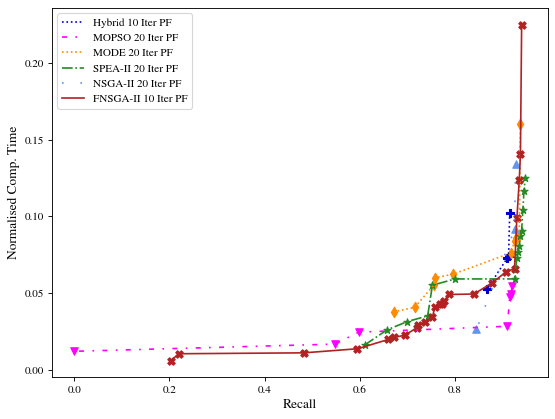

In [35]:
set_xlim = (0.8,.95)
set_ylim = (0,0.25)

plot_PF(nondom_sols, f'_{data_set}_{objective2}_10_hyb_', show_or_save=1, lims=False)